<a href="https://colab.research.google.com/github/KoNozaki/quantmacro-hw/blob/main/%E5%AE%9A%E9%87%8F%E7%9A%84%E3%83%9E%E3%82%AF%E3%83%AD%E7%B5%8C%E6%B8%88%E5%AD%A6_%E6%9C%9F%E6%9C%AB%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 定量的マクロ経済学　期末課題

前半のように、新しく作ったgithubのリポジトリのリンク（前半とは別のリポジトリ！）を提出してください。そのリポジトリの中にpythonのコード(.ipynb)とそれぞれの問いに答えたpdfファイルを入れること。pdfファイルの中に図なども全て入れてください。（pdfファイルだけ読めばipynbファイルを見なくとも答えがわかるようにすること。）締切は7月24日23:59。
___________________________________________

近年所得格差が日本で問題になっている。格差是正のために色々な政策が考えられるが、その中 でも(労働所得税ではなく)資本所得税を増加させ、国民全員に再分配する政策を実行すべきか
どうか考えたい。資本所得税は資本の利子所得r aに比例する税金で、その税率をτkとする。その
ために、日本のマクロ経済をコンピュータ上に表現し、以下の順番で政策実験を行う。この課題 のためのgithubのリンクを新しく作って、その中に計算に使用したPythonコード(google colab)と 以下の問の答えを記述したpdfファイルを別々に用意し、そのリンクをCanvas経由で期限内に提出 すること。




#1
日本のマクロ経済を簡単に表現できる異質的な個人を含むモデルとその均衡の定義を記述せよ。

政府は上であげたような資本所得税を課税して、全員に同じだけ再分配している。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [1]:
# Tauchen法
def tauchen(n, mu, rho, sigma):
    # 入力：
      # n: グリッド点の数
      # mu: AR(1)過程の平均
      # rho: AR(1)の係数
      # sigma: 誤差項の標準偏差
    # 出力：
      # transition_matrix: n x n の遷移行列
      # state_space: n x 1 の状態空間の点のベクトル

    m = 1 / np.sqrt(1 - rho**2) # AR(1)過程の誤差項の標準偏差を計算

    # 状態空間を計算
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # グリッド間の距離を計算
    d = (state_space[n-1] - state_space[0]) / (n - 1)

    # 遷移確率を計算
    transition_matrix = np.zeros((n, n))
    for i in range(n): # 今日の状態
        for j in range(n): # 明日の状態
            if j == 0: # 下限への遷移確率
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1: # 上限への遷移確率
                transition_matrix[i, j] = 1 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                z_low = (state_space[j] - rho*state_space[i] - d/2) / sigma # 下限
                z_high = (state_space[j] - rho*state_space[i] + d/2) / sigma # 上限
                transition_matrix[i, j] = norm.cdf(z_high) - norm.cdf(z_low) # その他のグリッドポイントへの遷移確率

    return transition_matrix, state_space

In [2]:
# - setPar：パラメータの設定
def setPar(
    sigma = 1.50, # リスク回避度
    beta = 0.98, # 時間割引率
    delta = 0.03, # 減価償却率
    alpha = 0.25, # 資本の所得シェア
    rho = 0.6, # 労働生産性の持続性
    a_l = 0, # 資産グリッドの下限
    a_u = 20, # 資産グリッドの上限
    NH = 2, # hのグリッド数
    NA = 401, # aのグリッド数
    ):

    # 労働生産性の分散
    sigma_eps = np.sqrt(0.6*(1-rho**2))

    # hの対数に対するグリッドを作成し、tauchen法を用いて所得遷移確率を求める
    pi, h = tauchen(NH, -0.7, rho, sigma_eps)
    h = np.exp(h) # changing ln h grids to h grids

    # 所得遷移過程から定常分布を導出

    probst = np.ones((NH))/NH # 均一分布に対する初期推定値
    test = 10.0 # 距離を大きな値で初期化

    while test > 1e-8: # 定常分布が収束するまでループ
        probst_new = np.zeros((NH)) # 新しい分布を初期化
        for ih in range(NH): # 今日のh
            for ihp in range(NH): # 明日のh
                probst_new[ihp] += pi[ih, ihp]*probst[ih]

        test = np.max(np.abs(probst_new - probst)) # 推定値と新しい分布の差を計算
        probst = probst_new # 推定値を更新

    HH = np.sum(h*probst) # 総有効労働

	  # パラメータの辞書を作成
    param = {}
    param['sigma'] = sigma; param['beta'] = beta; param['delta'] = delta;
    param['alpha'] = alpha; param['probst'] = probst;
    param['a_l'] = a_l; param['a_u'] = a_u; param['NH'] = NH; param['NA'] = NA;
    param['pi'] = pi; param['h'] = h; param['HH'] = HH;

    return param

In [3]:
# - solve_household_gs：家計の最適化問題を解く
def solve_household_gs(param, r, w):

    # opening the box of "param" to some parameters
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH'];

    # Create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize the utility function to a large negative number for zero or negative consumption
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility if the agent chooses asset a[iap] for each asset combination a[ia] and income shock h[ih]
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)


    # Initialize some variables
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # Iterate on Bellman's equation and get the decision rules and the value function at the optimum
    test = 10
    while test != 0: # loop until policy function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        # Finding max of reward
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # finding the maximal value
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # finding the index of the maximizer

        test = np.max(iaplus_new - iaplus) # stop if iaplus converges
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    # optimal consumption
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

In [4]:
# - get_distribution：最適な貯蓄の決定に基づいた定常状態の分布を計算

def get_distribution(param, decisions):

    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi'];
    NA = param['NA']; NH = param['NH'];
    iaplus = decisions[1]

    # Generate a linearly spaced vector of NA values between a_l and a_u
    a = np.linspace(a_l, a_u, NA)

    test = 10 # Initialize a test value to be greater than 10^-8
    phi = np.ones((NA, NH)) / NA / NH # Initialize the distribution phi to be uniform

    # Loop until the test value is less than 10^-8
    while test > 1e-8:
        phi_new = np.zeros((NA, NH)) # Initialize a new distribution phi_new to be all zeros
        # Loop over all values of a, h, and h'
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    # Update phi_new using the interpolation indices, blending coefficients, and probabilities
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]
        test = np.max(np.abs(phi_new - phi)) # Calculate the maximum difference between phi_new and phi
        phi = phi_new # Update phi to be phi_new

    return phi

In [5]:
# - model_solution：マクロ経済の定常状態を計算

def model_solution(param):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']

    phi = 0.2 # updating share
    toler = 1e-3 # warning: this doens't converge if tolerance is too small
    test = 10 # initial difference
    KK = 10.0 # initial capital

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # Step 1
        # calculate rental rate of capital and w from firm FOC

        w = (1-alpha) * KK**(alpha) * HH**(-alpha)
        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta

        ####################################################
        # Step 2: Solving for households optimization (policy function of assets)
        ####################################################

        decisions = solve_household_gs(param, r, w)

        aplus = decisions[0] # note that the first component (index 0) of decisions is defines as aplus

        ####################################################
        # Step 3: Loop for finding eq distribution and capital
        ####################################################

        # eq distribution

        mu = get_distribution(param, decisions)

        # new aggregate capital

        KK_new = np.sum(mu*aplus)

        ####################################################
        # Loop for finding eq capital
        ####################################################

        # form metric and update KK

        test = abs((KK_new - KK)/KK) # loop until K converges
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # update K

    return decisions, r, w, KK, HH, mu

In [6]:
# パラメータの設定
param = setPar()

# マクロ経済の定常状態を計算
(decisions, r, w, KK, HH, mu) = model_solution(param)

# decisions: 家計の最適な貯蓄と消費の決定
# r: 資本のレンタルレート
# w: 労働賃金
# KK: 資本の定常状態の量
# HH: 労働の定常状態の量
# mu: 家計の資産と生産性ショックの定常状態の分布

ITERATING ON KK

  metric    Kold      Knew
['0.5521', '10.0000', '4.4794']
['0.3771', '8.8959', '5.5410']
['0.1315', '8.2249', '7.1431']
['0.0205', '8.0085', '8.1730']
['0.0025', '8.0414', '8.0614']
['0.0015', '8.0454', '8.0337']
['0.0023', '8.0431', '8.0614']
['0.0031', '8.0467', '8.0219']
['0.0024', '8.0418', '8.0614']
['0.0091', '8.0457', '7.9724']
['0.0117', '8.0310', '8.1249']
['0.0083', '8.0498', '7.9828']
['0.0039', '8.0364', '8.0676']
['0.0005', '8.0426', '8.0386']


#2
τk = 0の時の定常状態均衡(総資本K、賃金w、利子率r)を計算せよ。

そして横軸を所得wh + ra、縦軸を各所得ごとの割合とした分布の図を描け。

さらに横軸を資産aとした同様の図も描くこと。

パラメータの値は講義中で共有したgoogle colabのノートブックで扱ったものとする。これが資本所得税導入前の日本経済となる。

In [7]:
# 総資本、賃金、利子率を表示
print(f"定常状態での総資本: {KK}")
print(f"定常状態での賃金: {w}")
print(f"定常状態での利子率: {r}")

定常状態での総資本: 8.041822600504139
定常状態での賃金: 1.3033754232108015
定常状態での利子率: 0.017633798605864934


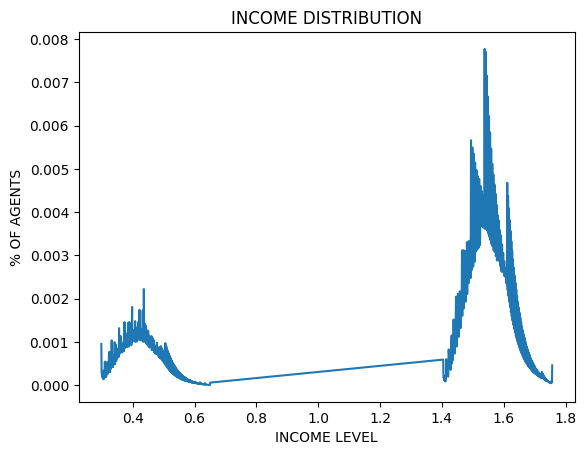

In [8]:
# 所得分布を計算しプロット
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

h = param['h']

# Calculate income distribution for each grid
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
# Transpose income
income = income.T
# Sort the income after flattening "income"
pinc, index = np.sort(income.flatten('F')), np.argsort(income.flatten('F'))
plambda = mu.flatten('F')[index]

# Plot income distribution
plt.figure()
plt.plot(pinc, plambda)
plt.title('INCOME DISTRIBUTION')
plt.xlabel('INCOME LEVEL')
plt.ylabel('% OF AGENTS')
plt.show()

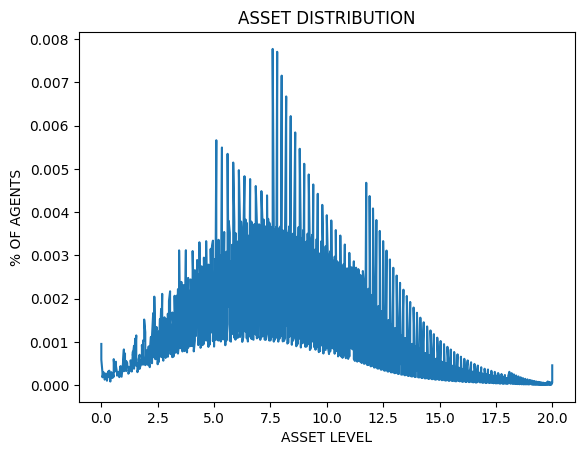

In [9]:
# 資産分布を計算しプロット
# Calculate asset distribution for each grid
assets = np.array([a, a])
# Transpose assets
assets = assets.T
# Sort the assets after flattening "assets"
passets, index = np.sort(assets.flatten('F')), np.argsort(assets.flatten('F'))
plambda = mu.flatten('F')[index]

# Plot asset distribution
plt.figure()
plt.plot(passets, plambda)
plt.title('ASSET DISTRIBUTION')
plt.xlabel('ASSET LEVEL')
plt.ylabel('% OF AGENTS')
plt.show()

#3

上のモデルを使い、資本所得税率τkを0%から5%に増加させる実験をする。その増加分は
全国民(家計)に全員同じ決まった額だけもらえる形で再分配する。ただし、政府の予算制約は毎期必ず均衡しなくてはいけない。

このモデルにおいて定常状態均衡を計算し、

上の問題のように所得と資産の分布の図を描け。

このモデルに基づくと資本所得税を増加させると日本経済の所得格差はどう変化するか?
数値で答えること。

GDPは何%変化するか?

あなたが政策担当者ならば資本所得税は増加させるか?その理由は?

In [10]:
# - solve_household_gs_2：家計の最適化問題を解く
def solve_household_gs_2(param, r, w, tau_k, T):

    # Opening the box of "param" to some parameters
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH'];

    # Create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize the utility function to a large negative number for zero or negative consumption
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility if the agent chooses asset a[iap] for each asset combination a[ia] and income shock h[ih]
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap] - tau_k*r*a[ia] + T
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # Initialize some variables
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # Iterate on Bellman's equation and get the decision rules and the value function at the optimum
    test = 10
    while test != 0: # loop until policy function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        # Finding max of reward
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # finding the maximal value
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # finding the index of the maximizer

        test = np.max(iaplus_new - iaplus) # stop if iaplus converges
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    # optimal consumption
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r*(1-tau_k))*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

In [11]:
# - model_solution_2：マクロ経済の定常状態を計算
def model_solution_2(param, tau_k, T):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']

    phi = 0.2 # updating share
    toler = 1e-3 # warning: this doens't converge if tolerance is too small
    test = 10 # initial difference
    KK = 10.0 # initial capital

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # Step 1
        # calculate rental rate of capital and w from firm FOC

        w = (1-alpha) * KK**(alpha) * HH**(-alpha)
        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta

        ####################################################
        # Step 2: Solving for households optimization (policy function of assets)
        ####################################################

        decisions = solve_household_gs_2(param, r, w, tau_k, T)

        aplus = decisions[0] # note that the first component (index 0) of decisions is defines as aplus

        ####################################################
        # Step 3: Loop for finding eq distribution and capital
        ####################################################

        # eq distribution

        mu = get_distribution(param, decisions)

        # new aggregate capital

        KK_new = np.sum(mu*aplus)

        ####################################################
        # Loop for finding eq capital
        ####################################################

        # form metric and update KK

        test = abs((KK_new - KK)/KK) # loop until K converges
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # update K

    return decisions, r, w, KK, HH, mu

In [14]:
# Recalculate the steady state with the new tax rate tau_k
# Calculate total tax revenue
tau_k = 0.05
param['tau_k'] = tau_k
T = tau_k * r * np.sum(a[:, np.newaxis] * mu)
(decisions, r, w, KK, HH, mu) = model_solution_2(param, tau_k, T)

ITERATING ON KK

  metric    Kold      Knew
['0.5666', '10.0000', '4.3338']
['0.4077', '8.8668', '5.2521']
['0.1813', '8.1438', '6.6672']
['0.0065', '7.8485', '7.8994']
['0.0009', '7.8587', '7.8657']


資本所得税の導入により総資本ストックが初期状態の10から7.8657に減少？

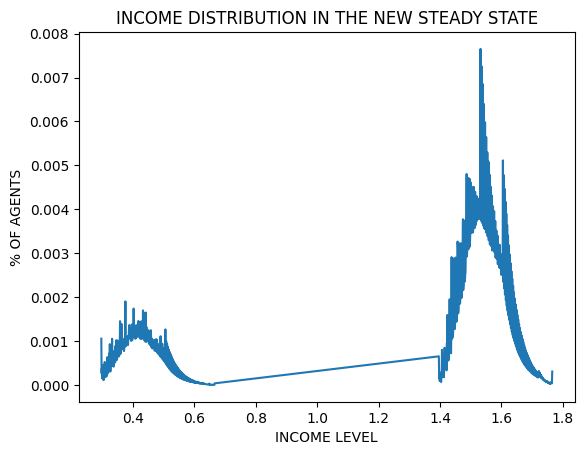

In [16]:
# Calculate income distribution for each grid in the new steady state
income_new = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
# Transpose income
income_new = income_new.T
# Sort the income after flattening "income_new"
pinc_new, index_new = np.sort(income_new.flatten('F')), np.argsort(income_new.flatten('F'))
plambda_new = mu.flatten('F')[index_new]

# Plot income distribution in the new steady state
plt.figure()
plt.plot(pinc_new, plambda_new)
plt.title('INCOME DISTRIBUTION IN THE NEW STEADY STATE')
plt.xlabel('INCOME LEVEL')
plt.ylabel('% OF AGENTS')
plt.show()

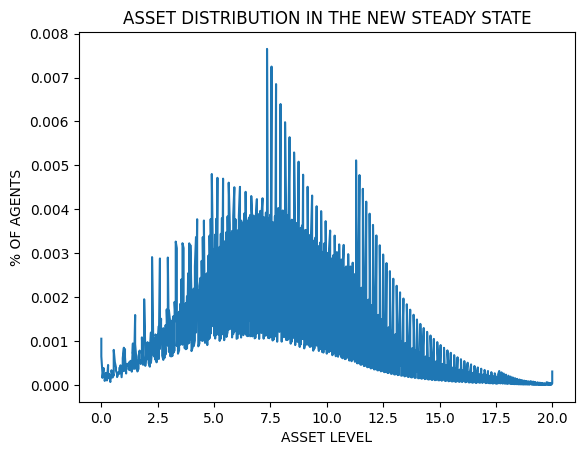

In [17]:
# Calculate asset distribution for each grid in the new steady state
assets_new = np.array([a, a])
# Transpose assets
assets_new = assets_new.T
# Sort the assets after flattening "assets_new"
passets_new, index_new = np.sort(assets_new.flatten('F')), np.argsort(assets_new.flatten('F'))
plambda_new = mu.flatten('F')[index_new]

# Plot asset distribution in the new steady state
plt.figure()
plt.plot(passets_new, plambda_new)
plt.title('ASSET DISTRIBUTION IN THE NEW STEADY STATE')
plt.xlabel('ASSET LEVEL')
plt.ylabel('% OF AGENTS')
plt.show()

In [18]:
#所得格差をジニ係数であらわあしてみる
# Function to calculate Gini coefficient
def gini(x):
    mad = np.abs(np.subtract.outer(x, x)).mean()  # Mean absolute difference
    rmad = mad/np.mean(x)  # Relative mean absolute difference
    return 0.5 * rmad  # Gini coefficient

# Calculate income distribution for each grid
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
income = income.T

# Flatten the income and calculate the Gini coefficient
income_flat = income.flatten('F')
gini_before = gini(income_flat)

# Recalculate the steady state with the new tax rate tau_k
tau_k = 0.05
param['tau_k'] = tau_k
T = tau_k * r * np.sum(a[:, np.newaxis] * mu)
(decisions, r, w, KK, HH, mu) = model_solution_2(param, tau_k, T)

# Calculate income distribution for each grid
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
income = income.T

# Flatten the income and calculate the Gini coefficient
income_flat = income.flatten('F')
gini_after = gini(income_flat)

# The change in income inequality
change_in_inequality = gini_after - gini_before
print("Change in income inequality: ", change_in_inequality)

ITERATING ON KK

  metric    Kold      Knew
['0.5666', '10.0000', '4.3338']
['0.4077', '8.8668', '5.2521']
['0.1851', '8.1438', '6.6365']
['0.0075', '7.8424', '7.9016']
['0.0048', '7.8542', '7.8162']
['0.0070', '7.8466', '7.9015']
['0.0012', '7.8576', '7.8666']
['0.0011', '7.8594', '7.8511']
['0.0002', '7.8577', '7.8563']
Change in income inequality:  -6.268935834885525e-06


ジニ係数の変化は約
−
6.27
×
1
0
−
6
−6.27×10
−6
  となっています。ジニ係数は所得格差を表す指標であり、値が大きいほど格差が大きいことを示します。この結果から、資本所得税率を 0% から 5% に増加させると、所得格差（ジニ係数）が微小ながらも減少することが読み取れます。

In [20]:
#GDPの変化
# Recalculate the steady state with the new tax rate tau_k
# Calculate total tax revenue
tau_k = 0.05
param['tau_k'] = tau_k
T = tau_k * r * np.sum(a[:, np.newaxis] * mu)
(decisions_new, r_new, w_new, KK_new, HH_new, mu_new) = model_solution_2(param, tau_k, T)

# Calculate GDP before the tax change
Y_before = KK**(param['alpha']) * HH**(1-param['alpha'])

# Calculate GDP after the tax change
Y_after = KK_new**(param['alpha']) * HH_new**(1-param['alpha'])

# Calculate the percentage change in GDP
GDP_change = ((Y_after - Y_before) / Y_before) * 100
GDP_change


ITERATING ON KK

  metric    Kold      Knew
['0.5666', '10.0000', '4.3338']
['0.4077', '8.8668', '5.2521']
['0.1851', '8.1438', '6.6365']
['0.0075', '7.8424', '7.9016']
['0.0048', '7.8542', '7.8162']
['0.0070', '7.8466', '7.9015']
['0.0047', '7.8576', '7.8948']
['0.0051', '7.8650', '7.8247']
['0.0001', '7.8570', '7.8563']


-0.001959036747868137

この結果は、資本所得税率を0%から5%に増加させた場合、GDPは約-0.002%減少することを示しています。つまり、このモデルによれば、資本所得税の増税はほとんどGDPに影響を与えないと言えます。

このモデルの結果を基に考えると、資本所得税の増税は所得格差の縮小に貢献する一方で、全体のGDPにはほとんど影響を及ぼさないという結果が出ています。これは、資本所得の増税によって高所得者からより多くの税金を徴収し、それを全ての国民に再分配することで、所得格差が縮小されるというメカニズムを示しています。